# Initial Setup 

In [333]:
import pandas as pd 
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [624]:
df = pd.read_csv("../raw_data/data/BDI/cleaned_daily_BDI.csv")

df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

df.head(2)

,Price
Date,
1995-01-03,1964.0
1995-01-04,1961.0


# Scaling the dataset & manual Holdout method

### Holdout method

Train/val/test split = (7:2:1)

In [625]:
input_length = len(df)

In [626]:
def train_test_split(df:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple:
    '''
    Returns a train dataframe and a test dataframe (df_train, df_test)
    from which one can sample (X,y) sequences using TimeseriesGenerator.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    
    # TRAIN SET

    last_train_idx = round(train_test_ratio * len(df))
    df_train = df.iloc[0:last_train_idx, :]

    # TEST SET
 
    first_test_idx = last_train_idx - input_length
    df_test = df.iloc[first_test_idx:, :]

    return (df_train, df_test)

In [627]:
df_train, df_test = train_test_split(df=df, train_test_ratio=0.8, input_length=input_length)

In [628]:
len(df_train)

4000

In [629]:
len(df_test)

1000

# TimeseriesGenerator for sequences

In [630]:
X_train = df_train
y_train = df_train["Price"]

X_test  = df_test
y_test = df_test["Price"]

In [631]:
scaler = MinMaxScaler()

In [577]:
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)


In [578]:
# y_train_scaled = scaler.fit_transform(y_train)
# y_test_scaled = scaler.fit_transform(y_test)

In [673]:
generator = TimeseriesGenerator(X_train, y_train, length=7, batch_size=6, sampling_rate=1, stride=1)

In [674]:
generator_val = TimeseriesGenerator(X_test, y_test, length=7, batch_size=6, sampling_rate=1, stride=1)

In [675]:
for X, y in generator:
    print(X.shape, y.shape)
    print(X[0], y[0])
    break

(6, 7, 1) (6,)
[[1964.]
 [1961.]
 [1967.]
 [1983.]
 [1994.]
 [2015.]
 [2019.]] 2038.0


# The model

In [676]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [677]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

In [919]:
rmsprop = RMSprop(learning_rate=0.0001)
adam = Adam(learning_rate=lr_schedule)

In [852]:
def init_model():
    
    model = Sequential()

    #LSTM layers
    model.add(layers.LSTM(400, activation="tanh", input_shape=(7,1), return_sequences=False))

    #Dense layers
    model.add(layers.Dense(150, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))

    #compiling model
    model.compile(loss="mse", optimizer=rmsprop, metrics="mae")
    
    return model

# Training & Testing 

In [701]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor="val_mae", patience=30, restore_best_weights=True)

In [702]:
model = init_model()

In [703]:
history = model.fit(
    generator, epochs=100, validation_data=generator_val, shuffle=True, callbacks=es
)

Epoch 1/100
666/666 [==============================] - 10s 12ms/step - loss: 8603959.0000 - mae: 2003.0972 - val_loss: 402097.9062 - val_mae: 569.8585
Epoch 2/100
666/666 [==============================] - 7s 11ms/step - loss: 4623577.0000 - mae: 1382.0402 - val_loss: 1108157.6250 - val_mae: 980.6452
Epoch 3/100
666/666 [==============================] - 7s 11ms/step - loss: 3619362.2500 - mae: 1210.1147 - val_loss: 768201.5000 - val_mae: 814.6632
Epoch 4/100
666/666 [==============================] - 7s 11ms/step - loss: 2745729.0000 - mae: 969.1602 - val_loss: 588612.8125 - val_mae: 687.8508
Epoch 5/100
666/666 [==============================] - 7s 10ms/step - loss: 1963908.7500 - mae: 749.5281 - val_loss: 285627.0625 - val_mae: 459.9814
Epoch 6/100
666/666 [==============================] - 7s 10ms/step - loss: 1400211.5000 - mae: 598.0226 - val_loss: 127928.5391 - val_mae: 305.2206
Epoch 7/100
666/666 [==============================] - 7s 11ms/step - loss: 1225997.7500 - mae: 482.0

666/666 [==============================] - 8s 11ms/step - loss: 279657.7812 - mae: 291.5478 - val_loss: 10822.7705 - val_mae: 80.9403
Epoch 57/100
666/666 [==============================] - 7s 11ms/step - loss: 310677.7812 - mae: 288.3050 - val_loss: 25561.8906 - val_mae: 124.3749
Epoch 58/100
666/666 [==============================] - 8s 11ms/step - loss: 365907.1875 - mae: 317.2220 - val_loss: 19507.7051 - val_mae: 112.5691
Epoch 59/100
666/666 [==============================] - 7s 10ms/step - loss: 362435.5938 - mae: 315.6026 - val_loss: 18281.5703 - val_mae: 94.3517
Epoch 60/100
666/666 [==============================] - 7s 11ms/step - loss: 308090.1875 - mae: 296.2497 - val_loss: 71370.3047 - val_mae: 204.2868
Epoch 61/100
666/666 [==============================] - 7s 11ms/step - loss: 257722.4688 - mae: 279.2150 - val_loss: 22501.8848 - val_mae: 96.4797
Epoch 62/100
666/666 [==============================] - 7s 10ms/step - loss: 309606.1250 - mae: 309.9362 - val_loss: 14198.5283 

In [694]:
model.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 400)               643200    
                                                                 
 dense_100 (Dense)           (None, 128)               51328     
                                                                 
 dense_101 (Dense)           (None, 1)                 129       
                                                                 
Total params: 694,657
Trainable params: 694,657
Non-trainable params: 0
_________________________________________________________________


array([<AxesSubplot: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

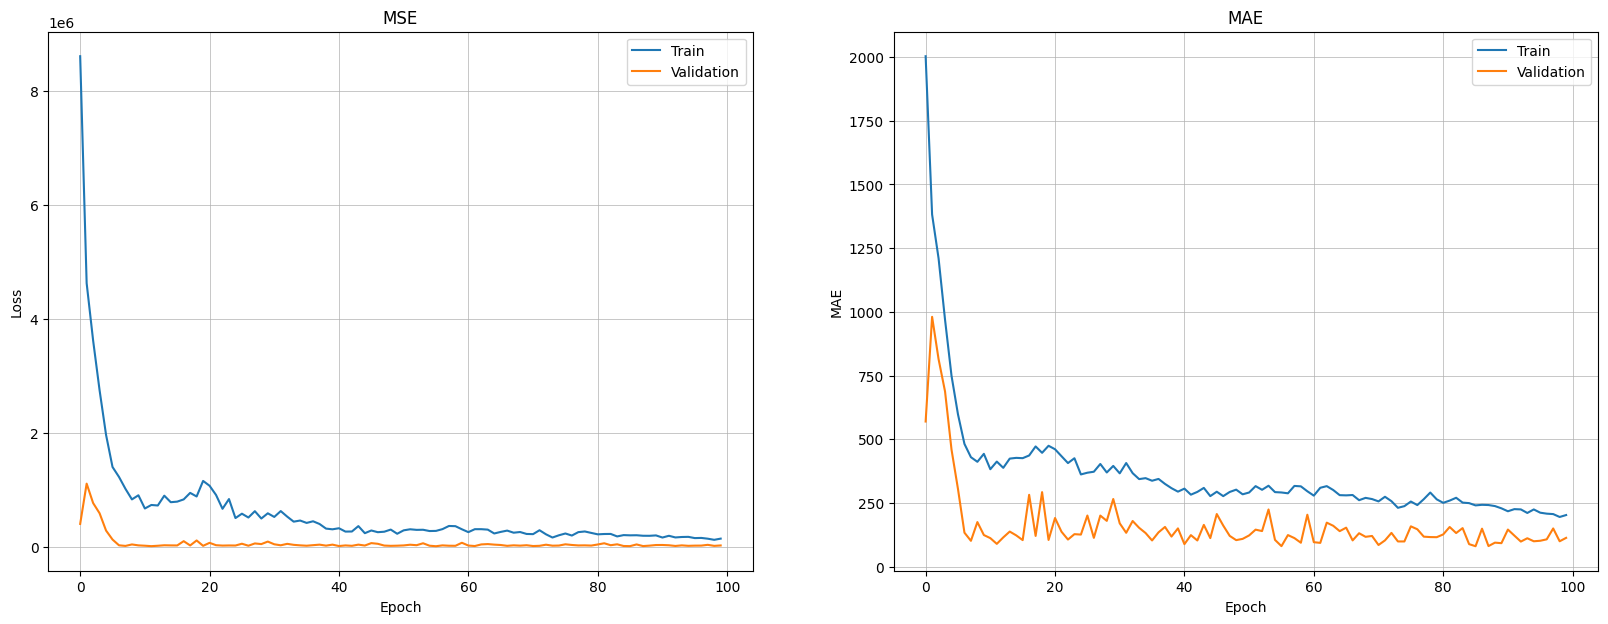

In [718]:
plot_history(history)

# Setup code for learning curves

In [686]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [705]:
model.save("univariate model")

INFO:tensorflow:Assets written to: univariate model/assets


INFO:tensorflow:Assets written to: univariate model/assets


In [708]:
history.params


{'verbose': 1, 'epochs': 100, 'steps': 666}

In [732]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [734]:
min(history.history["mae"])

195.4354705810547

In [736]:
min(history.history["val_mae"])

80.67047882080078

# Second Training!

In [938]:
df2 = pd.read_csv("../raw_data/data/BDI/cleaned_weekly_BDI.csv")

In [941]:
df2.head(2)

,time,close
0,1995-01-16,2059.0
1,1995-01-23,1983.0


In [967]:
df2.set_index(df2["time"], inplace=True)

KeyError: 'time'

In [968]:
df2.drop(columns="time", inplace=True)

KeyError: "['time'] not found in axis"

In [969]:
d1 = df2[df2.index < "2009-01-01"]
d2 = df2[df2.index > "2014-12-30"]

In [970]:
dfs = [d1, d2]
concat_df = pd.concat(dfs)

In [971]:
df_train_concat, df_test_concat = train_test_split(df=concat_df, train_test_ratio=0.8, input_length=input_length)

In [972]:
X_train_concat = df_train_concat
y_train_concat = df_train_concat["close"]

X_test_concat = df_test_concat
y_test_concat = df_test_concat["close"]

In [973]:
generator2 = TimeseriesGenerator(X_train_concat,
                                 y_train_concat,
                                 length=8,
                                 batch_size=8,
                                 sampling_rate=1,
                                 stride=1,
                                 shuffle=False)

In [974]:
generator_val2 = TimeseriesGenerator(X_test_concat,
                                     y_test_concat,
                                     length=8, 
                                     batch_size=8,
                                     sampling_rate=1,
                                     stride=1,
                                     shuffle=False)

In [975]:
len(generator2)

113

In [976]:
for X, y in generator2:
    print(X.shape, y.shape)
    print(X[0], y[0])
    

(8, 8, 1) (8,)
[[2059.]
 [1983.]
 [1959.]
 [1980.]
 [1992.]
 [2027.]
 [2066.]
 [2176.]] 2266.0
(8, 8, 1) (8,)
[[2266.]
 [2289.]
 [2209.]
 [2205.]
 [2247.]
 [2299.]
 [2347.]
 [2343.]] 2299.0
(8, 8, 1) (8,)
[[2299.]
 [2208.]
 [2129.]
 [2055.]
 [1995.]
 [1997.]
 [2001.]
 [1979.]] 1937.0
(8, 8, 1) (8,)
[[1937.]
 [1958.]
 [1983.]
 [2016.]
 [2059.]
 [2084.]
 [2107.]
 [2122.]] 2096.0
(8, 8, 1) (8,)
[[2096.]
 [2048.]
 [2000.]
 [1979.]
 [1920.]
 [1828.]
 [1745.]
 [1656.]] 1559.0
(8, 8, 1) (8,)
[[1559.]
 [1542.]
 [1636.]
 [1748.]
 [1707.]
 [1634.]
 [1606.]
 [1644.]] 1623.0
(8, 8, 1) (8,)
[[1623.]
 [1604.]
 [1583.]
 [1550.]
 [1538.]
 [1529.]
 [1484.]
 [1453.]] 1437.0
(8, 8, 1) (8,)
[[1437.]
 [1400.]
 [1357.]
 [1350.]
 [1363.]
 [1422.]
 [1448.]
 [1458.]] 1450.0
(8, 8, 1) (8,)
[[1450.]
 [1448.]
 [1465.]
 [1458.]
 [1445.]
 [1417.]
 [1379.]
 [1339.]] 1322.0
(8, 8, 1) (8,)
[[1322.]
 [1276.]
 [1232.]
 [1193.]
 [1157.]
 [1116.]
 [1106.]
 [1078.]] 1062.0
(8, 8, 1) (8,)
[[1062.]
 [1062.]
 [1101.]
 [1119.]

In [989]:
def init_model2():
    
    model = Sequential()

    #LSTM layers
    model.add(layers.LSTM(128, activation="tanh", input_shape=(8,1), return_sequences=False))

    #Dense layers
    model.add(layers.Dense(50, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))

    #compiling model
    model.compile(loss="mse", optimizer=rmsprop, metrics="mae")
    
    return model

In [990]:
model2 = init_model2()

Input length, two weeks <br>
predict one week into the future.

In [991]:
es2 = EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)

In [992]:
history2 = model2.fit(generator2, epochs=1000, validation_data=generator_val2, shuffle=True, callbacks=es2)

Epoch 1/1000
113/113 [==============================] - 2s 8ms/step - loss: 10219906.0000 - mae: 2341.8320 - val_loss: 8980805.0000 - val_mae: 2229.2505
Epoch 2/1000
113/113 [==============================] - 0s 3ms/step - loss: 10212444.0000 - mae: 2340.2468 - val_loss: 8974542.0000 - val_mae: 2227.8354
Epoch 3/1000
113/113 [==============================] - 0s 3ms/step - loss: 10206738.0000 - mae: 2338.9304 - val_loss: 8968791.0000 - val_mae: 2226.5469
Epoch 4/1000
113/113 [==============================] - 0s 3ms/step - loss: 10200395.0000 - mae: 2337.6353 - val_loss: 8963061.0000 - val_mae: 2225.2585
Epoch 5/1000
113/113 [==============================] - 0s 3ms/step - loss: 10194592.0000 - mae: 2336.3452 - val_loss: 8957062.0000 - val_mae: 2223.9136
Epoch 6/1000
113/113 [==============================] - 0s 3ms/step - loss: 10187646.0000 - mae: 2334.8540 - val_loss: 8950330.0000 - val_mae: 2222.3689
Epoch 7/1000
113/113 [==============================] - 0s 3ms/step - loss: 101797

KeyboardInterrupt: 

In [ ]:
plot_history(history2)